In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
from scipy import stats  # For statistical functions
from scipy.stats import norm
sns.set_style("darkgrid")  # Setting seaborn plot style

from sklearn.model_selection import train_test_split

# Read the dataset
df = pd.read_csv('Asteroid_Updated.csv', low_memory=False)

# Display the first few rows of the dataset
df.head()

# Display the value counts of 'spec_T' column
df.spec_T.value_counts().sort_values(ascending=False).head()
# Note: Uncomment the line above to see all classes of 'spec_T' and 'spec_B'

# Analyze missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(12)

# Creating main dataset with selected columns
columns = ['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'n_obs_used', 'H', 'diameter', 'albedo', 'rot_per', 'moid', 'n', 'per', 'ma']
df = df[columns]

# Remove rows with null values in 'diameter' and 'rot_per' columns
df = df.dropna(subset=["diameter", "rot_per"])

# Remove non-numeric values from 'diameter' column
df = df[pd.to_numeric(df['diameter'], errors='coerce').notnull()]

# Interpolate missing values
df = df.interpolate()

# Round float values to 5 decimal places
df = df.round(decimals=5)

# Convert dataframe to float type
df = df.astype(float)

# Reset dataframe index
df = df.reset_index()

# Display the first few rows of the modified dataset
df.head()


,index,a,e,i,om,w,q,ad,per_y,data_arc,n_obs_used,H,diameter,albedo,rot_per,moid,n,per,ma
0,0,2.76917,0.07601,10.59407,80.30553,73.59769,2.55868,2.97965,4.60820,8822.0,1002.0,3.34,939.400,0.0900,9.07417,1.59478,0.21389,1683.14571,77.37210
1,1,2.77247,0.23034,34.83623,173.08006,310.04886,2.13386,3.41107,4.61644,72318.0,8490.0,4.13,545.000,0.1010,7.81320,1.23324,0.21350,1686.15600,59.69913
2,2,2.66915,0.25694,12.98892,169.85276,248.13863,1.98333,3.35497,4.36081,72684.0,7104.0,5.33,246.596,0.2140,7.21000,1.03454,0.22602,1592.78729,34.92502
3,3,2.36142,0.08872,7.14177,103.81080,150.72854,2.15191,2.57093,3.62884,24288.0,9325.0,3.20,525.400,0.4228,5.34213,1.13948,0.27161,1325.43276,95.86194
4,4,2.57425,0.19109,5.36699,141.57660,358.68761,2.08232,3.06617,4.13032,63507.0,2916.0,6.85,106.699,0.2740,16.80600,1.09589,0.23863,1508.60046,282.36629


In [3]:
# Display descriptive statistics of the dataframe
df.describe()
# This provides summary statistics like mean, standard deviation, min, max, and quartiles for each numerical column

# Removing outliers based on predefined thresholds
df = df[df.a < 20]  # Remove rows where 'a' is greater than 20
df = df[df.q < 6]   # Remove rows where 'q' is greater than 6
df = df[df.n_obs_used < 6000]  # Remove rows where 'n_obs_used' is greater than 6000
df = df[df.per_y < 15]   # Remove rows where 'per_y' is greater than 15
df = df[df.diameter < 400]  # Remove rows where 'diameter' is greater than 400
df = df.reset_index()  # Reset dataframe index after removal

# Display correlation between 'diameter' and other attributes
corr_matrix = df.corr()
corr_matrix["diameter"].sort_values(ascending=False).head()
# This shows the correlation coefficient between 'diameter' and other attributes
# Positive values suggest a positive correlation, negative values suggest a negative correlation, and zero suggests no correlation

# Dropping columns with low correlation
columns.remove("rot_per")  # Remove 'rot_per' from columns list
columns.remove("w")        # Remove 'w' from columns list
columns.remove("om")       # Remove 'om' from columns list
df = df[columns]           # Select only the columns with higher correlation with 'diameter'
df.head()                  # Display the first few rows of the modified dataframe


,a,e,i,q,ad,per_y,data_arc,n_obs_used,H,diameter,albedo,moid,n,per,ma
0,2.57425,0.19109,5.36699,2.08232,3.06617,4.13032,63507.0,2916.0,6.85,106.699,0.2740,1.09589,0.23863,1508.60046,282.36629
1,2.38533,0.23121,5.52365,1.83383,2.93684,3.68410,62452.0,5206.0,5.51,199.830,0.2766,0.84610,0.26753,1345.61920,140.41966
2,2.20176,0.15650,5.88695,1.85719,2.54634,3.26711,62655.0,2744.0,6.49,147.491,0.2260,0.87418,0.30168,1193.31372,194.88290
3,2.38564,0.12311,5.57682,2.09193,2.67934,3.68481,61821.0,2649.0,6.28,190.000,0.1180,1.10691,0.26748,1345.87536,276.86162
4,2.45311,0.10047,4.62989,2.20664,2.69958,3.84223,61755.0,5492.0,6.55,142.887,0.1910,1.19322,0.25652,1403.37519,278.93069


<Axes: >

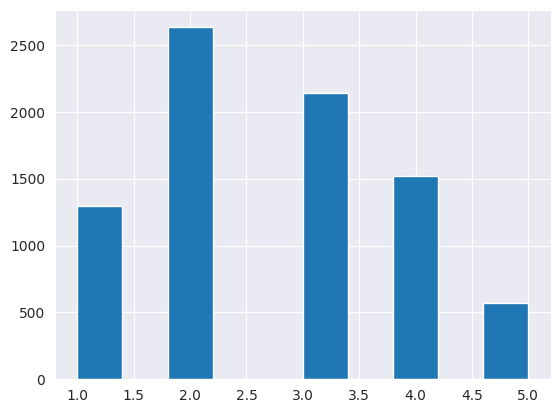

In [4]:
# Creating a copy of the dataframe
df1 = df.copy()

# Extracting the target variable 'diameter' and removing it from the copied dataframe
y = df1.pop('diameter')

# Displaying the first few rows of the copied dataframe (now without the 'diameter' column)
df1.head()

# Creating a new column 'diameter_grp' based on specified bins and labels
df['diameter_grp'] = pd.cut(df['diameter'],
                            bins=[0., 4., 8., 18., 60., np.inf],  # Define bin ranges
                            labels=[1, 2, 3, 4, 5])  # Assign labels to each bin

# Plotting a histogram to visualize the distribution of samples in each diameter group
df["diameter_grp"].hist()


In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

# Initialize StratifiedShuffleSplit for splitting the data into train and test sets
split = StratifiedShuffleSplit(test_size=0.2, random_state=1)
# The test size is set to 20% of the data, and a random state is specified for reproducibility

# Iterate over the indices generated by the split
for train_index, test_index in split.split(df, df['diameter_grp']):
    # Select rows for training and testing sets based on the indices
    dftrain = df.loc[train_index]  # Training set
    dftest = df.loc[test_index]    # Test set

# Creating target datasets for training and testing sets
ytrain = dftrain.pop('diameter')  # Extract 'diameter' column as target for training set
ytest = dftest.pop('diameter')    # Extract 'diameter' column as target for test set

# Display the first few rows of the training set
dftrain.head()


,a,e,i,q,ad,per_y,data_arc,n_obs_used,H,albedo,moid,n,per,ma,diameter_grp
7089,2.23973,0.09535,4.59299,2.02618,2.45329,3.35199,8959.0,1717.0,14.6,0.280,1.01699,0.29404,1224.31427,254.48696,1
5675,3.08188,0.12383,9.18294,2.70026,3.46350,5.41043,11173.0,1330.0,13.0,0.098,1.72632,0.18217,1976.16082,177.66423,3
2600,3.96084,0.12903,2.77259,3.44979,4.47189,7.88295,23947.0,2184.0,12.1,0.324,2.45362,0.12503,2879.24850,95.51826,3
2546,2.66553,0.18102,16.41015,2.18302,3.14803,4.35194,23596.0,2168.0,11.6,0.132,1.22851,0.22648,1589.54534,320.33566,4
5275,3.05576,0.07083,9.82038,2.83931,3.27221,5.34180,11197.0,1661.0,13.1,0.149,1.87667,0.18451,1951.09104,280.07351,3


In [6]:
ytrain.head()


7089     3.019
5675    10.373
2600    10.185
2546    18.984
5275     8.647
Name: diameter, dtype: float64

In [7]:
df['diameter_grp'].value_counts() / len(df)


diameter_grp
2    0.322470
3    0.262558
4    0.185984
1    0.158785
5    0.070203
Name: count, dtype: float64

In [8]:
dftrain['diameter_grp'].value_counts() / len(dftrain)

diameter_grp
2    0.322561
3    0.262521
4    0.185940
1    0.158830
5    0.070149
Name: count, dtype: float64

In [9]:
# Iterate over the training and test sets
for set_ in (dftrain, dftest):
    # Drop the 'diameter_grp' column along the columns axis (axis=1)
    set_.drop("diameter_grp", axis=1, inplace=True)

# Display the first few rows of the training set to confirm the changes
dftrain.head()


,a,e,i,q,ad,per_y,data_arc,n_obs_used,H,albedo,moid,n,per,ma
7089,2.23973,0.09535,4.59299,2.02618,2.45329,3.35199,8959.0,1717.0,14.6,0.280,1.01699,0.29404,1224.31427,254.48696
5675,3.08188,0.12383,9.18294,2.70026,3.46350,5.41043,11173.0,1330.0,13.0,0.098,1.72632,0.18217,1976.16082,177.66423
2600,3.96084,0.12903,2.77259,3.44979,4.47189,7.88295,23947.0,2184.0,12.1,0.324,2.45362,0.12503,2879.24850,95.51826
2546,2.66553,0.18102,16.41015,2.18302,3.14803,4.35194,23596.0,2168.0,11.6,0.132,1.22851,0.22648,1589.54534,320.33566
5275,3.05576,0.07083,9.82038,2.83931,3.27221,5.34180,11197.0,1661.0,13.1,0.149,1.87667,0.18451,1951.09104,280.07351


In [10]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scale = MinMaxScaler()

# Fit and transform the training set
sdftrain = scale.fit_transform(dftrain)

# Transform the test set using the same scaler fitted on the training set
sdftest = scale.transform(dftest)

# Display the scaled training set
sdftrain  # All the values now lie between 0 to 1


array([[0.2867631 , 0.10600162, 0.08196597, ..., 0.18124547, 0.1995131 ,
        0.70687184],
       [0.4583178 , 0.13804627, 0.16464653, ..., 0.09007262, 0.35789381,
        0.4933495 ],
       [0.63737108, 0.14389712, 0.04917439, ..., 0.04350413, 0.54813432,
        0.26503165],
       ...,
       [0.4752991 , 0.13162159, 0.34257684, ..., 0.08424544, 0.37489772,
        0.86497707],
       [0.46336778, 0.24048112, 0.08606798, ..., 0.08830409, 0.36292703,
        0.97755241],
       [0.31092519, 0.21650389, 0.1299358 , ..., 0.1633972 , 0.22026917,
        0.53509316]])

interactive(children=(FloatSlider(value=5.5, description='height', max=8.0, min=4.0), FloatSlider(value=2.5, d…

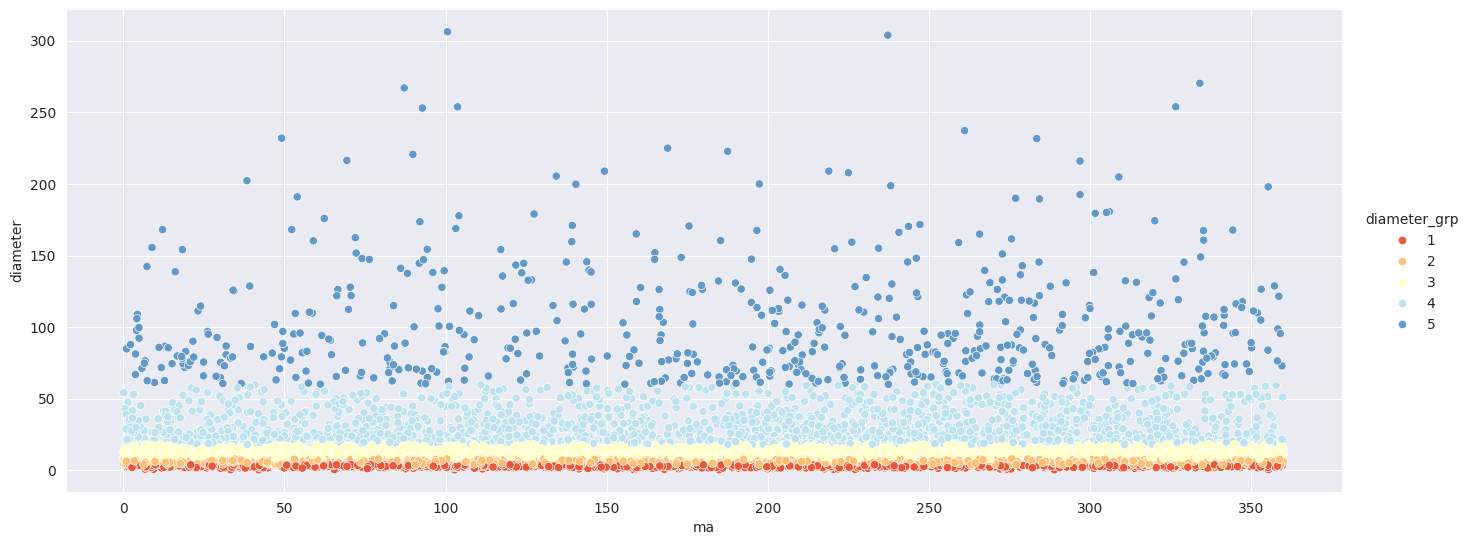

In [11]:
from ipywidgets import interactive
import seaborn as sns

def size_widget(height=5.5, aspect=2.5, Y='diameter', X='ma', Kind='scatter'):
    sns.pairplot(df, hue='diameter_grp', palette='RdYlBu', x_vars=X, y_vars=Y, height=height, aspect=aspect, kind=Kind)

# Create the interactive widget
interactive_plot = interactive(size_widget, height=(4, 8, 0.1), aspect=(1, 5, 0.1), Y=df.columns, X=df.columns, Kind=['scatter', 'reg'])

# Display the widget
interactive_plot


In [12]:
print("Skewness: %f" % df['diameter'].skew())
print("Kurtosis: %f" % df['diameter'].kurt())

Skewness: 3.696485
Kurtosis: 18.108458


ML Prediction for main objective

In [13]:
from sklearn.linear_model import LinearRegression

# Initialize the linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(dftrain, ytrain)

# Make predictions on the test data
pred = model.predict(dftest)

# Display the predictions
pred


array([18.49162463,  5.70034288, -5.75637182, ..., 33.48827813,
       54.41866298, 33.61140211])

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate mean squared error (MSE)
linearMSE = mean_squared_error(pred, ytest)

# Calculate root mean squared error (RMSE)
linearRMSE = mean_squared_error(pred, ytest, squared=False)

# Calculate mean absolute error (MAE)
linearMAE = mean_absolute_error(pred, ytest)

# Print the calculated metrics
print("Mean Squared Error (MSE):", linearMSE)
print("Root Mean Squared Error (RMSE):", linearRMSE)
print("Mean Absolute Error (MAE):", linearMAE)


Mean Squared Error (MSE): 197.91191107372964
Root Mean Squared Error (RMSE): 14.068116827554768
Mean Absolute Error (MAE): 9.026830942476426


In [15]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest regressor with specified parameters
model = RandomForestRegressor(random_state=0, max_depth=10)

# Fit the model on the training data
model.fit(dftrain, ytrain)

# Make predictions on the test data
pred = model.predict(dftest)

# Display the predictions
pred


array([ 7.43434286,  7.08310442,  3.35389953, ..., 12.9720273 ,
       64.84226309, 13.71700994])

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate mean squared error (MSE) for Random Forest
RandomForestMSE = mean_squared_error(pred, ytest)

# Calculate root mean squared error (RMSE) for Random Forest
RandomForestRMSE = mean_squared_error(pred, ytest, squared=False)

# Calculate mean absolute error (MAE) for Random Forest
RandomForestMAE = mean_absolute_error(pred, ytest)

# Print the calculated metrics for Random Forest
print("Random Forest Mean Squared Error (MSE):", RandomForestMSE)
print("Random Forest Root Mean Squared Error (RMSE):", RandomForestRMSE)
print("Random Forest Mean Absolute Error (MAE):", RandomForestMAE)


Random Forest Mean Squared Error (MSE): 9.439758031767004
Random Forest Root Mean Squared Error (RMSE): 3.072418921919178
Random Forest Mean Absolute Error (MAE): 1.3870175739693276


In [17]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize the KNN regressor
model = KNeighborsRegressor()

# Fit the model on the scaled training data
model.fit(sdftrain, ytrain)

# Make predictions on the scaled test data
pred = model.predict(sdftest)

# Display the predictions
pred


array([  7.8022,   8.2182,   3.3632, ...,  10.265 , 100.479 ,  13.9432])

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate mean squared error (MSE) for KNN
knn_MSE = mean_squared_error(pred, ytest)

# Calculate root mean squared error (RMSE) for KNN
knn_RMSE = mean_squared_error(pred, ytest, squared=False)

# Calculate mean absolute error (MAE) for KNN
knn_MAE = mean_absolute_error(pred, ytest)

# Print the calculated metrics for KNN
print("KNN Mean Squared Error (MSE):", knn_MSE)
print("KNN Root Mean Squared Error (RMSE):", knn_RMSE)
print("KNN Mean Absolute Error (MAE):", knn_MAE)


KNN Mean Squared Error (MSE): 87.09784710554808
KNN Root Mean Squared Error (RMSE): 9.332622734555816
KNN Mean Absolute Error (MAE): 3.858450459277403


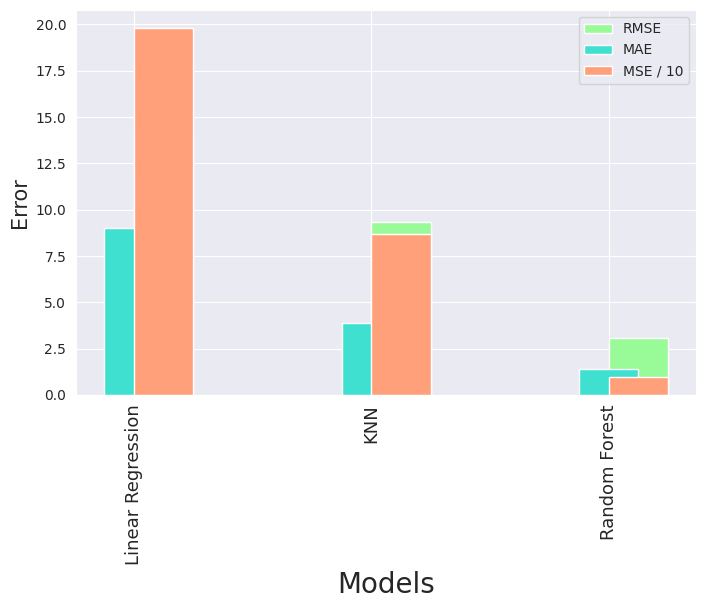

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Models and corresponding error values
models = ['Linear Regression', 'KNN', 'Random Forest']
ValuesM = [linearMSE/10, knn_MSE/10, RandomForestMSE/10]
ValuesR = [linearRMSE, knn_RMSE, RandomForestRMSE]
ValuesA = [linearMAE, knn_MAE, RandomForestMAE]
ypos = np.arange(len(models))

# Set the size of the graph
plt.figure(figsize=(8, 5))

# Set the rotation angle and fontsize for x and y ticks
plt.xticks(rotation=90, fontsize=13)
plt.yticks(fontsize=10)

# Plot RMSE
plt.bar(models, ValuesR, width=0.25, align='edge', color='palegreen', label="RMSE")
# Plot MAE
plt.bar(models, ValuesA, width=0.25, align='center', color='turquoise', label="MAE")
# Plot MSE
plt.bar(models, ValuesM, width=0.25, align='edge', color='lightsalmon', label="MSE / 10")

# Set labels and legend
plt.xlabel("Models", fontsize=20)
plt.ylabel("Error", fontsize=15, rotation=90)
plt.legend()

plt.show()


In [25]:
# Sample data for Ceres (replace with actual data)
name = "Ceres"
semi_major_axis = 2.769165155  # Semi-major axis in AU
eccentricity = 0.076009029  # Eccentricity
inclination = 10.59406704  # Inclination in degrees
orbital_period = 1683.145708  # Orbital period in years

# Estimate initial conditions
initial_conditions = estimate_initial_conditions(semi_major_axis, eccentricity, inclination, orbital_period)

# Simulate trajectory for 100 years with a time step of 1 year
t = np.linspace(0, 100, 1000)  # Time array in years
x, y, z = simulate_trajectory(initial_conditions, t)

# Print trajectory coordinates
print("Trajectory coordinates (x, y, z):")
for i in range(len(t)):
    print(f"Time: {t[i]} years, Position: ({x[i]}, {y[i]}, {z[i]}) AU")


Trajectory coordinates (x, y, z):
Time: 0.0 years, Position: (2.5586836004278157, 0.0, 0.0) AU
Time: 0.1001001001001001 years, Position: (2.5586836004278157, 0.0, 0.0) AU
Time: 0.2002002002002002 years, Position: (2.5586836004278157, 0.0, 0.0) AU
Time: 0.3003003003003003 years, Position: (2.5586836004278157, 0.0, 0.0) AU
Time: 0.4004004004004004 years, Position: (2.5586836004278157, 0.0, 0.0) AU
Time: 0.5005005005005005 years, Position: (2.5586836004278157, 0.0, 0.0) AU
Time: 0.6006006006006006 years, Position: (2.5586836004278157, 0.0, 0.0) AU
Time: 0.7007007007007008 years, Position: (2.5586836004278157, 0.0, 0.0) AU
Time: 0.8008008008008008 years, Position: (2.5586836004278157, 0.0, 0.0) AU
Time: 0.9009009009009009 years, Position: (2.5586836004278157, 0.0, 0.0) AU
Time: 1.001001001001001 years, Position: (2.5586836004278157, 0.0, 0.0) AU
Time: 1.1011011011011012 years, Position: (2.5586836004278157, 0.0, 0.0) AU
Time: 1.2012012012012012 years, Position: (2.5586836004278157, 0.0, 0.

In [26]:
# Sample data for Pallas
name_pallas = "Pallas"
semi_major_axis_pallas = 2.772465922
eccentricity_pallas = 0.230336821
inclination_pallas = 34.83623442
orbital_period_pallas = 1686.155999

# Estimate initial conditions for Pallas
initial_conditions_pallas = estimate_initial_conditions(semi_major_axis_pallas, eccentricity_pallas, inclination_pallas, orbital_period_pallas)

# Simulate trajectory for Pallas for 100 years with a time step of 1 year
t_pallas = np.linspace(0, 100, 1000)
x_pallas, y_pallas, z_pallas = simulate_trajectory(initial_conditions_pallas, t_pallas)

# Print trajectory coordinates for Pallas
print("Trajectory coordinates for Pallas (x, y, z):")
for i in range(len(t_pallas)):
    print(f"Time: {t_pallas[i]} years, Position: ({x_pallas[i]}, {y_pallas[i]}, {z_pallas[i]}) AU")

Trajectory coordinates for Pallas (x, y, z):
Time: 0.0 years, Position: (2.133864935195686, 0.0, 0.0) AU
Time: 0.1001001001001001 years, Position: (2.133864935195686, 0.0, 0.0) AU
Time: 0.2002002002002002 years, Position: (2.133864935195686, 0.0, 0.0) AU
Time: 0.3003003003003003 years, Position: (2.133864935195686, 0.0, 0.0) AU
Time: 0.4004004004004004 years, Position: (2.133864935195686, 0.0, 0.0) AU
Time: 0.5005005005005005 years, Position: (2.133864935195686, 0.0, 0.0) AU
Time: 0.6006006006006006 years, Position: (2.133864935195686, 0.0, 0.0) AU
Time: 0.7007007007007008 years, Position: (2.133864935195686, 0.0, 0.0) AU
Time: 0.8008008008008008 years, Position: (2.133864935195686, 0.0, 0.0) AU
Time: 0.9009009009009009 years, Position: (2.133864935195686, 0.0, 0.0) AU
Time: 1.001001001001001 years, Position: (2.133864935195686, 0.0, 0.0) AU
Time: 1.1011011011011012 years, Position: (2.133864935195686, 0.0, 0.0) AU
Time: 1.2012012012012012 years, Position: (2.133864935195686, 0.0, 0.0)

In [27]:
# Sample data for Juno
name_juno = "Juno"
semi_major_axis_juno = 2.669149517
eccentricity_juno = 0.25694232
inclination_juno = 12.98891913
orbital_period_juno = 1592.787285

# Estimate initial conditions for Juno
initial_conditions_juno = estimate_initial_conditions(semi_major_axis_juno, eccentricity_juno, inclination_juno, orbital_period_juno)

# Simulate trajectory for Juno for 100 years with a time step of 1 year
t_juno = np.linspace(0, 100, 1000)
x_juno, y_juno, z_juno = simulate_trajectory(initial_conditions_juno, t_juno)

# Print trajectory coordinates for Juno
print("Trajectory coordinates for Juno (x, y, z):")
for i in range(len(t_juno)):
    print(f"Time: {t_juno[i]} years, Position: ({x_juno[i]}, {y_juno[i]}, {z_juno[i]}) AU")

Trajectory coordinates for Juno (x, y, z):
Time: 0.0 years, Position: (1.9833320476751406, 0.0, 0.0) AU
Time: 0.1001001001001001 years, Position: (1.9833320476751406, 0.0, 0.0) AU
Time: 0.2002002002002002 years, Position: (1.9833320476751406, 0.0, 0.0) AU
Time: 0.3003003003003003 years, Position: (1.9833320476751406, 0.0, 0.0) AU
Time: 0.4004004004004004 years, Position: (1.9833320476751406, 0.0, 0.0) AU
Time: 0.5005005005005005 years, Position: (1.9833320476751406, 0.0, 0.0) AU
Time: 0.6006006006006006 years, Position: (1.9833320476751406, 0.0, 0.0) AU
Time: 0.7007007007007008 years, Position: (1.9833320476751406, 0.0, 0.0) AU
Time: 0.8008008008008008 years, Position: (1.9833320476751406, 0.0, 0.0) AU
Time: 0.9009009009009009 years, Position: (1.9833320476751406, 0.0, 0.0) AU
Time: 1.001001001001001 years, Position: (1.9833320476751406, 0.0, 0.0) AU
Time: 1.1011011011011012 years, Position: (1.9833320476751406, 0.0, 0.0) AU
Time: 1.2012012012012012 years, Position: (1.9833320476751406

In [28]:
# Sample data for Vesta
name_vesta = "Vesta"
semi_major_axis_vesta = 2.361417896
eccentricity_vesta = 0.08872146
inclination_vesta = 7.141770812
orbital_period_vesta = 1325.432765

# Estimate initial conditions for Vesta
initial_conditions_vesta = estimate_initial_conditions(semi_major_axis_vesta, eccentricity_vesta, inclination_vesta, orbital_period_vesta)

# Simulate trajectory for Vesta for 100 years with a time step of 1 year
t_vesta = np.linspace(0, 100, 1000)
x_vesta, y_vesta, z_vesta = simulate_trajectory(initial_conditions_vesta, t_vesta)

# Print trajectory coordinates for Vesta
print("Trajectory coordinates for Vesta (x, y, z):")
for i in range(len(t_vesta)):
    print(f"Time: {t_vesta[i]} years, Position: ({x_vesta[i]}, {y_vesta[i]}, {z_vesta[i]}) AU")

Trajectory coordinates for Vesta (x, y, z):
Time: 0.0 years, Position: (2.1519094525967515, 0.0, 0.0) AU
Time: 0.1001001001001001 years, Position: (2.1519094525967515, 0.0, 0.0) AU
Time: 0.2002002002002002 years, Position: (2.1519094525967515, 0.0, 0.0) AU
Time: 0.3003003003003003 years, Position: (2.1519094525967515, 0.0, 0.0) AU
Time: 0.4004004004004004 years, Position: (2.1519094525967515, 0.0, 0.0) AU
Time: 0.5005005005005005 years, Position: (2.1519094525967515, 0.0, 0.0) AU
Time: 0.6006006006006006 years, Position: (2.1519094525967515, 0.0, 0.0) AU
Time: 0.7007007007007008 years, Position: (2.1519094525967515, 0.0, 0.0) AU
Time: 0.8008008008008008 years, Position: (2.1519094525967515, 0.0, 0.0) AU
Time: 0.9009009009009009 years, Position: (2.1519094525967515, 0.0, 0.0) AU
Time: 1.001001001001001 years, Position: (2.1519094525967515, 0.0, 0.0) AU
Time: 1.1011011011011012 years, Position: (2.1519094525967515, 0.0, 0.0) AU
Time: 1.2012012012012012 years, Position: (2.151909452596751

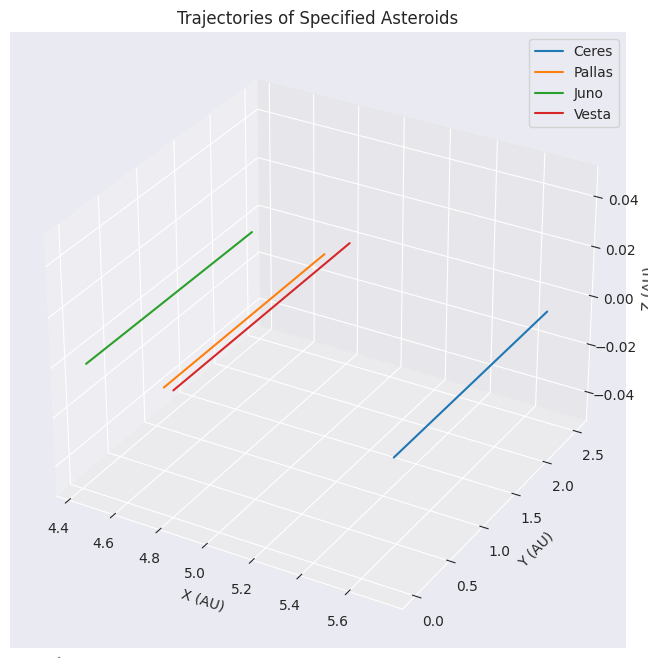

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to estimate initial conditions
def estimate_initial_conditions(semi_major_axis, eccentricity, inclination, orbital_period):
    # Conversion factor from AU to km
    au_to_km = 1.496e+8

    # Semi-major axis in km
    semi_major_axis_km = semi_major_axis * au_to_km

    # Mean motion (angular speed) in radians per year
    mean_motion = 2 * np.pi / orbital_period

    # Convert inclination to radians
    inclination_rad = np.radians(inclination)

    # Initial position in orbital plane (perifocal coordinates)
    initial_x = semi_major_axis_km * (np.cos(0) - eccentricity)
    initial_y = semi_major_axis_km * np.sqrt(1 - eccentricity**2) * np.sin(0)

    # Initial velocity in orbital plane (perifocal coordinates)
    initial_vx = -semi_major_axis_km * mean_motion * np.sin(0)
    initial_vy = semi_major_axis_km * mean_motion * np.sqrt(1 - eccentricity**2) * np.cos(0)

    return (initial_x, initial_y, 0, initial_vx, initial_vy, 0)

# Function to simulate trajectory
def simulate_trajectory(initial_conditions, t):
    # Gravitational parameter (GM) for the Sun
    GM_sun = 1.32712440018e20  # in m^3/s^2

    # Convert initial conditions to SI units (meters and seconds)
    initial_conditions_SI = np.array(initial_conditions) * 1.496e+8

    # Extract initial position and velocity components
    x0, y0, z0, vx0, vy0, vz0 = initial_conditions_SI

    # Initialize arrays to store trajectory
    x = np.zeros_like(t)
    y = np.zeros_like(t)
    z = np.zeros_like(t)

    # Initial positions
    x[0] = x0
    y[0] = y0
    z[0] = z0

    # Initial velocities
    vx = vx0
    vy = vy0
    vz = vz0

    # Integrate equations of motion using simple Euler method
    for i in range(1, len(t)):
        # Time step
        dt = t[i] - t[i-1]

        # Gravitational force from the Sun
        r = np.sqrt(x[i-1]**2 + y[i-1]**2 + z[i-1]**2)
        F_gravity = -GM_sun / r**3 * np.array([x[i-1], y[i-1], z[i-1]])

        # Update velocities
        vx += F_gravity[0] * dt
        vy += F_gravity[1] * dt
        vz += F_gravity[2] * dt

        # Update positions
        x[i] = x[i-1] + vx * dt
        y[i] = y[i-1] + vy * dt
        z[i] = z[i-1] + vz * dt

    return x, y, z

# Data for the specified asteroids
asteroids = [
    {"name": "Ceres", "a": 2.769165155, "e": 0.076009029, "i": 10.59406704, "per_y": 1683.145708},
    {"name": "Pallas", "a": 2.772465922, "e": 0.230336821, "i": 34.83623442, "per_y": 1686.155999},
    {"name": "Juno", "a": 2.669149517, "e": 0.25694232, "i": 12.98891913, "per_y": 1592.787285},
    {"name": "Vesta", "a": 2.361417896, "e": 0.08872146, "i": 7.141770812, "per_y": 1325.432765}
]

# Plotting trajectories
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for asteroid in asteroids:
    name = asteroid["name"]
    semi_major_axis = asteroid["a"]
    eccentricity = asteroid["e"]
    inclination = asteroid["i"]
    orbital_period = asteroid["per_y"]

    # Estimate initial conditions
    initial_conditions = estimate_initial_conditions(semi_major_axis, eccentricity, inclination, orbital_period)

    # Simulate trajectory for 100 years with a time step of 1 year
    t = np.linspace(0, 100, 1000)
    x, y, z = simulate_trajectory(initial_conditions, t)

    # Plot trajectory
    ax.plot(x, y, z, label=name)

# Set labels and title
ax.set_xlabel('X (AU)')
ax.set_ylabel('Y (AU)')
ax.set_zlabel('Z (AU)')
ax.set_title('Trajectories of Specified Asteroids')
ax.legend()

# Show plot
plt.show()


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_asteroids = pd.read_csv('dataset.csv', low_memory=False)

In [42]:
from collections import namedtuple

# Define a named tuple to store orbital parameters
Orbit = namedtuple("Orbit", "e a i")

# Dictionary to store orbital parameters for planets
planets = {
    "Mercury": Orbit(0.206,  0.3871,  7.00),
    "Venus":   Orbit(0.007,  0.7233,  3.39),
    "Earth":   Orbit(0.017,  1.0000,  0.00),
    "Mars":    Orbit(0.093,  1.5273,  1.85),
    "Jupiter": Orbit(0.048,  5.2028,  1.31),
    "Saturn":  Orbit(0.056,  9.5388,  2.49),
    "Uranus":  Orbit(0.046, 19.1914,  0.77),
    "Neptune": Orbit(0.010, 30.0611,  1.77),
    "Pluto" :  Orbit(0.248, 39.5294, 17.15)
}

# Function to calculate distance to perihelion
def to_perihelion(a, e):
    return a * (1 - e)

# Function to calculate distance to aphelion
def to_aphelion(a, e):
    return a * (1 + e)

# Function to convert DataFrame to cumulative distribution function (CDF)
def to_cdf(df, col):
    MAX_STEPS = 40000
    # Sort the DataFrame based on the specified column
    cdf = df.sort_values(by=col).reset_index(drop=True)
    # Calculate percentiles
    cdf['percentile'] = 100 * (cdf.index + 1) / len(cdf)
    # Downsample if necessary
    skip = 1 if len(cdf) < MAX_STEPS else len(cdf) // MAX_STEPS
    return cdf[::skip]


In [43]:
def summarize_by_class( df ):
    OrbitClass = {
        'AMO' : 'Amor',
        'APO' : 'Apollo',
        'AST' : 'Asteroid (other)',
        'ATE' : 'Aten',
        'CEN' : 'Centaur',
        'HYA' : 'Hyperbolic Asteroid',
        'IEO' : 'Atira',
        'IMB' : 'Inner Main-belt Asteroid',
        'MBA' : 'Main-belt Asteroid',
        'MCA' : 'Mars Crossing Asteroid',
        'OMB' : 'Outer Main-belt Asteroid',
        'TJN' : 'Jupiter Trojan',
        'TNO' : 'TransNeptunian Object'
        }

    _ = df['class'].value_counts()
    return pd.DataFrame({
        'class': _.index,
        'count': _,
        'orbit_class' : _.index.map( OrbitClass)
    }).reset_index(drop=True)

summarize_by_class(df_asteroids)

,class,count,orbit_class
0,MBA,855954,Main-belt Asteroid
1,OMB,28355,Outer Main-belt Asteroid
2,IMB,20360,Inner Main-belt Asteroid
3,MCA,18685,Mars Crossing Asteroid
4,APO,12687,Apollo
5,AMO,8457,Amor
6,TJN,8221,Jupiter Trojan
7,TNO,3468,TransNeptunian Object
8,ATE,1729,Aten
9,CEN,506,Centaur


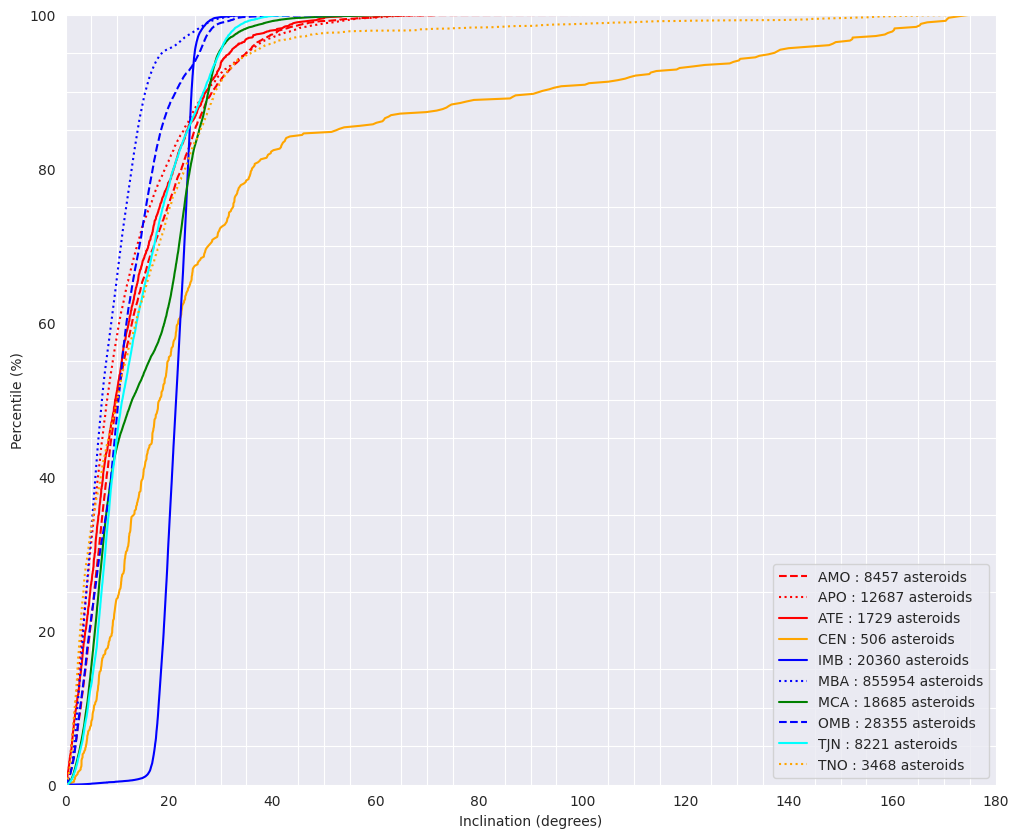

In [44]:
from collections import namedtuple
import matplotlib.pyplot as plt

# Define a named tuple to store line attributes
line_attr = namedtuple('line_attr', 'color style')

# Dictionary to store line attributes for different asteroid classes
styles = {
    'ATE': line_attr('red', 'solid'),
    'APO': line_attr('red', 'dotted'),
    'AMO': line_attr('red', 'dashed'),
    'MCA': line_attr('green', 'solid'),
    'IMB': line_attr('blue', 'solid'),
    'MBA': line_attr('blue', 'dotted'),
    'OMB': line_attr('blue', 'dashed'),
    'TJN': line_attr('cyan', 'solid'),
    'CEN': line_attr('orange', 'solid'),
    'TNO': line_attr('orange', 'dotted')
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 10))

# Iterate over asteroid classes and plot CDFs
for kls, group in df_asteroids.groupby('class'):
    # Check if line attributes are defined for the current class
    if kls not in styles:
        continue
    # Construct label for the legend
    label = f"{kls} : {len(group)} asteroids"
    # Retrieve color and line style from the styles dictionary
    c = styles[kls].color
    ls = styles[kls].style
    # Plot the CDF
    to_cdf(group, 'i').plot(ax=ax, x='i', y='percentile', c=c, ls=ls, label=label)

# Add minor ticks and grid
plt.minorticks_on()
plt.grid(which='both')

# Set labels and limits for the plot
plt.xlabel('Inclination (degrees)')
plt.ylabel('Percentile (%)')
plt.xlim(0, 180)
plt.ylim(0, 100)

# Show the legend
plt.legend()

# Display the plot
plt.show()
